# Calculate the solar position using a variety of methods/packages.

## Taken from https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/solarposition.html

### Contributors:
 * Rob Andrews (@Calama-Consulting), Calama Consulting, 2014
 * Will Holmgren (@wholmgren), University of Arizona, 2014
 * Tony Lorenzo (@alorenzo175), University of Arizona, 2015
 * Cliff Hansen (@cwhanse), Sandia National Laboratories, 2018

The main function is called "get_solarposition".  It takes as input:
* time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.
* latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.
* longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.
* altitude : None or float, default None
        If None, computed from pressure. Assumed to be 0 m
        if pressure is also None.
* pressure : None or float, default None
        If None, computed from altitude. Assumed to be 101325 Pa
        if altitude is also None.
* method : string, default 'nrel_numpy'
 * 'nrel_numpy' uses an implementation of the NREL SPA algorithm
        described in [1] (default, recommended): :py:func:`spa_python`
 * 'nrel_numba' uses an implementation of the NREL SPA algorithm
        described in [1], but also compiles the code first:
        :py:func:`spa_python`
 * 'pyephem' uses the PyEphem package: :py:func:`pyephem`
 * 'ephemeris' uses the pvlib ephemeris code: :py:func:`ephemeris`
 * 'nrel_c' uses the NREL SPA C code [3]: :py:func:`spa_c`
* temperature : float, default 12
        Degrees C.

The functions are then defined as follows

|No.| Function  | Description | Output      |
|---|-----------|-------------|-------------|
| 1.|spa_c      |Calculate the solar position using the C    | DataFrame with: elevation, azimuth, zenith,       |
|.  |.          |implementation of the NREL SPA code         | apparent_elevation, apparent_zenith               |
| 2.|spa_python |Calculate the solar position using a python | DataFrame with: apparent_zenith (degrees),        |
|.  |.          |implementation of the NREL SPA algorithm.   | zenith (degrees), apparent_elevation (degrees),   |
|.  |.          |.                                           | elevation (degrees), azimuth (degrees),           |
|.  |.          |.                                           | equation_of_time (minutes)                        |
| 3.|pyephem    |Calculate the solar position using the      | DataFrame with apparent_elevation, elevation,     |
|.  |.          |PyEphem package                             | apparent_azimuth, azimuth, apparent_zenith, zenith|
| 4.|ephemeris  |Python-native solar position calculator     | DataFrame with apparent_elevation, elevation,     |
|.  |.          |.                                           | azimuth (decimal degrees East of North),          |
|.  |.          |.                                           | apparent_zenith, zenith (solar zenith angle,      |
|.  |.          |.                                           | solar_time (decimal hours, noon is 12:00)         |

In [1]:
import os
import datetime as dt
try:
    from importlib import reload
except ImportError:
    try:
        from imp import reload
    except ImportError:
        pass

import numpy as np
import pandas as pd
import warnings

from pvlib import atmosphere
from pvlib.tools import datetime_to_djd, djd_to_datetime


NS_PER_HR = 1.e9 * 3600.  # nanoseconds per hour

In [2]:
def get_solarposition(time, latitude, longitude,
                      altitude=None, pressure=None,
                      method='nrel_numpy',
                      temperature=12, **kwargs):
    """
    A convenience wrapper for the solar position calculators.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.

    latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.

    longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.

    altitude : None or float, default None
        If None, computed from pressure. Assumed to be 0 m
        if pressure is also None.

    pressure : None or float, default None
        If None, computed from altitude. Assumed to be 101325 Pa
        if altitude is also None.

    method : string, default 'nrel_numpy'
        'nrel_numpy' uses an implementation of the NREL SPA algorithm
        described in [1] (default, recommended): :py:func:`spa_python`

        'nrel_numba' uses an implementation of the NREL SPA algorithm
        described in [1], but also compiles the code first:
        :py:func:`spa_python`

        'pyephem' uses the PyEphem package: :py:func:`pyephem`

        'ephemeris' uses the pvlib ephemeris code: :py:func:`ephemeris`

        'nrel_c' uses the NREL SPA C code [3]: :py:func:`spa_c`

    temperature : float, default 12
        Degrees C.

    kwargs
        Other keywords are passed to the solar position function
        specified by the ``method`` argument.

    References
    ----------
    .. [1] I. Reda and A. Andreas, Solar position algorithm for solar radiation
       applications. Solar Energy, vol. 76, no. 5, pp. 577-589, 2004.

    .. [2] I. Reda and A. Andreas, Corrigendum to Solar position algorithm for
       solar radiation applications. Solar Energy, vol. 81, no. 6, p. 838,
       2007.

    .. [3] NREL SPA code: http://rredc.nrel.gov/solar/codesandalgorithms/spa/
    """

    if altitude is None and pressure is None:
        altitude = 0.
        pressure = 101325.
    elif altitude is None:
        altitude = atmosphere.pres2alt(pressure)
    elif pressure is None:
        pressure = atmosphere.alt2pres(altitude)

    method = method.lower()
    if isinstance(time, dt.datetime):
        time = pd.DatetimeIndex([time, ])

    if method == 'nrel_c':
        ephem_df = spa_c(time, latitude, longitude, pressure, temperature,
                         **kwargs)
    elif method == 'nrel_numba':
        ephem_df = spa_python(time, latitude, longitude, altitude,
                              pressure, temperature,
                              how='numba', **kwargs)
    elif method == 'nrel_numpy':
        ephem_df = spa_python(time, latitude, longitude, altitude,
                              pressure, temperature,
                              how='numpy', **kwargs)
    elif method == 'pyephem':
        ephem_df = pyephem(time, latitude, longitude,
                           altitude=altitude,
                           pressure=pressure,
                           temperature=temperature, **kwargs)
    elif method == 'ephemeris':
        ephem_df = ephemeris(time, latitude, longitude, pressure, temperature,
                             **kwargs)
    else:
        raise ValueError('Invalid solar position method')

    return ephem_df

In [3]:
def spa_c(time, latitude, longitude, pressure=101325, altitude=0,
          temperature=12, delta_t=67.0,
          raw_spa_output=False):
    """
    Calculate the solar position using the C implementation of the NREL
    SPA code.

    The source files for this code are located in './spa_c_files/', along with
    a README file which describes how the C code is wrapped in Python.
    Due to license restrictions, the C code must be downloaded seperately
    and used in accordance with it's license.

    This function is slower and no more accurate than :py:func:`spa_python`.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.
    latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.
    longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.
    pressure : float, default 101325
        Pressure in Pascals
    altitude : float, default 0
        Height above sea level. [m]
    temperature : float, default 12
        Temperature in C
    delta_t : float, default 67.0
        Difference between terrestrial time and UT1.
        USNO has previous values and predictions.
    raw_spa_output : bool, default False
        If true, returns the raw SPA output.

    Returns
    -------
    DataFrame
        The DataFrame will have the following columns:
        elevation,
        azimuth,
        zenith,
        apparent_elevation,
        apparent_zenith.

    References
    ----------
    .. [1] NREL SPA reference:
       http://rredc.nrel.gov/solar/codesandalgorithms/spa/
       NREL SPA C files: https://midcdmz.nrel.gov/spa/

    Note: The ``timezone`` field in the SPA C files is replaced with
    ``time_zone`` to avoid a nameclash with the function ``__timezone`` that is
    redefined by Python>=3.5. This issue is
    `Python bug 24643 <https://bugs.python.org/issue24643>`_.

    .. [2] USNO delta T:
       http://www.usno.navy.mil/USNO/earth-orientation/eo-products/long-term

    See also
    --------
    pyephem, spa_python, ephemeris
    """

    # Added by Rob Andrews (@Calama-Consulting), Calama Consulting, 2014
    # Edited by Will Holmgren (@wholmgren), University of Arizona, 2014
    # Edited by Tony Lorenzo (@alorenzo175), University of Arizona, 2015

    try:
        from pvlib.spa_c_files.spa_py import spa_calc
    except ImportError:
        raise ImportError('Could not import built-in SPA calculator. ' +
                          'You may need to recompile the SPA code.')

    # if localized, convert to UTC. otherwise, assume UTC.
    try:
        time_utc = time.tz_convert('UTC')
    except TypeError:
        time_utc = time

    spa_out = []

    for date in time_utc:
        spa_out.append(spa_calc(year=date.year,
                                month=date.month,
                                day=date.day,
                                hour=date.hour,
                                minute=date.minute,
                                second=date.second,
                                time_zone=0,  # date uses utc time
                                latitude=latitude,
                                longitude=longitude,
                                elevation=altitude,
                                pressure=pressure / 100,
                                temperature=temperature,
                                delta_t=delta_t
                                ))

    spa_df = pd.DataFrame(spa_out, index=time)

    if raw_spa_output:
        # rename "time_zone" from raw output from spa_c_files.spa_py.spa_calc()
        # to "timezone" to match the API of pvlib.solarposition.spa_c()
        return spa_df.rename(columns={'time_zone': 'timezone'})
    else:
        dfout = pd.DataFrame({'azimuth': spa_df['azimuth'],
                              'apparent_zenith': spa_df['zenith'],
                              'apparent_elevation': spa_df['e'],
                              'elevation': spa_df['e0'],
                              'zenith': 90 - spa_df['e0']})

        return dfout

In [4]:
def _spa_python_import(how):
    """Compile spa.py appropriately"""

    from pvlib import spa

    # check to see if the spa module was compiled with numba
    using_numba = spa.USE_NUMBA

    if how == 'numpy' and using_numba:
        # the spa module was compiled to numba code, so we need to
        # reload the module without compiling
        # the PVLIB_USE_NUMBA env variable is used to tell the module
        # to not compile with numba
        warnings.warn('Reloading spa to use numpy')
        os.environ['PVLIB_USE_NUMBA'] = '0'
        spa = reload(spa)
        del os.environ['PVLIB_USE_NUMBA']
    elif how == 'numba' and not using_numba:
        # The spa module was not compiled to numba code, so set
        # PVLIB_USE_NUMBA so it does compile to numba on reload.
        warnings.warn('Reloading spa to use numba')
        os.environ['PVLIB_USE_NUMBA'] = '1'
        spa = reload(spa)
        del os.environ['PVLIB_USE_NUMBA']
    elif how != 'numba' and how != 'numpy':
        raise ValueError("how must be either 'numba' or 'numpy'")

    return spa

In [5]:
def spa_python(time, latitude, longitude,
               altitude=0, pressure=101325, temperature=12, delta_t=67.0,
               atmos_refract=None, how='numpy', numthreads=4, **kwargs):
    """
    Calculate the solar position using a python implementation of the
    NREL SPA algorithm.

    The details of the NREL SPA algorithm are described in [1]_.

    If numba is installed, the functions can be compiled to
    machine code and the function can be multithreaded.
    Without numba, the function evaluates via numpy with
    a slight performance hit.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.
    latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.
    longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.
    altitude : float, default 0
        Distance above sea level.
    pressure : int or float, optional, default 101325
        avg. yearly air pressure in Pascals.
    temperature : int or float, optional, default 12
        avg. yearly air temperature in degrees C.
    delta_t : float, optional, default 67.0
        If delta_t is None, uses spa.calculate_deltat
        using time.year and time.month from pandas.DatetimeIndex.
        For most simulations specifing delta_t is sufficient.
        Difference between terrestrial time and UT1.
        *Note: delta_t = None will break code using nrel_numba,
        this will be fixed in a future version.*
        The USNO has historical and forecasted delta_t [3].
    atmos_refrac : None or float, optional, default None
        The approximate atmospheric refraction (in degrees)
        at sunrise and sunset.
    how : str, optional, default 'numpy'
        Options are 'numpy' or 'numba'. If numba >= 0.17.0
        is installed, how='numba' will compile the spa functions
        to machine code and run them multithreaded.
    numthreads : int, optional, default 4
        Number of threads to use if how == 'numba'.

    Returns
    -------
    DataFrame
        The DataFrame will have the following columns:
        apparent_zenith (degrees),
        zenith (degrees),
        apparent_elevation (degrees),
        elevation (degrees),
        azimuth (degrees),
        equation_of_time (minutes).


    References
    ----------
    .. [1] I. Reda and A. Andreas, Solar position algorithm for solar
       radiation applications. Solar Energy, vol. 76, no. 5, pp. 577-589, 2004.

    .. [2] I. Reda and A. Andreas, Corrigendum to Solar position algorithm for
       solar radiation applications. Solar Energy, vol. 81, no. 6, p. 838,
       2007.

    .. [3] USNO delta T:
       http://www.usno.navy.mil/USNO/earth-orientation/eo-products/long-term

    See also
    --------
    pyephem, spa_c, ephemeris
    """

    # Added by Tony Lorenzo (@alorenzo175), University of Arizona, 2015

    lat = latitude
    lon = longitude
    elev = altitude
    pressure = pressure / 100  # pressure must be in millibars for calculation

    atmos_refract = atmos_refract or 0.5667

    if not isinstance(time, pd.DatetimeIndex):
        try:
            time = pd.DatetimeIndex(time)
        except (TypeError, ValueError):
            time = pd.DatetimeIndex([time, ])

    unixtime = np.array(time.astype(np.int64)/10**9)

    spa = _spa_python_import(how)

    delta_t = delta_t or spa.calculate_deltat(time.year, time.month)

    app_zenith, zenith, app_elevation, elevation, azimuth, eot = \
        spa.solar_position(unixtime, lat, lon, elev, pressure, temperature,
                           delta_t, atmos_refract, numthreads)

    result = pd.DataFrame({'apparent_zenith': app_zenith, 'zenith': zenith,
                           'apparent_elevation': app_elevation,
                           'elevation': elevation, 'azimuth': azimuth,
                           'equation_of_time': eot},
                          index=time)

    return result

In [6]:
def sun_rise_set_transit_spa(times, latitude, longitude, how='numpy',
                             delta_t=67.0, numthreads=4):
    """
    Calculate the sunrise, sunset, and sun transit times using the
    NREL SPA algorithm.

    The details of the NREL SPA algorithm are described in [1]_.

    If numba is installed, the functions can be compiled to
    machine code and the function can be multithreaded.
    Without numba, the function evaluates via numpy with
    a slight performance hit.

    Parameters
    ----------
    times : pandas.DatetimeIndex
        Must be localized to the timezone for ``latitude`` and ``longitude``.
    latitude : float
        Latitude in degrees, positive north of equator, negative to south
    longitude : float
        Longitude in degrees, positive east of prime meridian, negative to west
    delta_t : float, optional
        If delta_t is None, uses spa.calculate_deltat
        using times.year and times.month from pandas.DatetimeIndex.
        For most simulations specifing delta_t is sufficient.
        Difference between terrestrial time and UT1.
        delta_t = None will break code using nrel_numba,
        this will be fixed in a future version.
        By default, use USNO historical data and predictions
    how : str, optional, default 'numpy'
        Options are 'numpy' or 'numba'. If numba >= 0.17.0
        is installed, how='numba' will compile the spa functions
        to machine code and run them multithreaded.
    numthreads : int, optional, default 4
        Number of threads to use if how == 'numba'.

    Returns
    -------
    pandas.DataFrame
        index is the same as input `times` argument
        columns are 'sunrise', 'sunset', and 'transit'

    References
    ----------
    .. [1] Reda, I., Andreas, A., 2003. Solar position algorithm for solar
       radiation applications. Technical report: NREL/TP-560- 34302. Golden,
       USA, http://www.nrel.gov.
    """
    # Added by Tony Lorenzo (@alorenzo175), University of Arizona, 2015

    lat = latitude
    lon = longitude

    # times must be localized
    if times.tz:
        tzinfo = times.tz
    else:
        raise ValueError('times must be localized')

    # must convert to midnight UTC on day of interest
    utcday = pd.DatetimeIndex(times.date).tz_localize('UTC')
    unixtime = np.array(utcday.astype(np.int64)/10**9)

    spa = _spa_python_import(how)

    delta_t = delta_t or spa.calculate_deltat(times.year, times.month)

    transit, sunrise, sunset = spa.transit_sunrise_sunset(
        unixtime, lat, lon, delta_t, numthreads)

    # arrays are in seconds since epoch format, need to conver to timestamps
    transit = pd.to_datetime(transit*1e9, unit='ns', utc=True).tz_convert(
        tzinfo).tolist()
    sunrise = pd.to_datetime(sunrise*1e9, unit='ns', utc=True).tz_convert(
        tzinfo).tolist()
    sunset = pd.to_datetime(sunset*1e9, unit='ns', utc=True).tz_convert(
        tzinfo).tolist()

    return pd.DataFrame(index=times, data={'sunrise': sunrise,
                                           'sunset': sunset,
                                           'transit': transit})

In [7]:
def _ephem_convert_to_seconds_and_microseconds(date):
    # utility from unreleased PyEphem 3.6.7.1
    """Converts a PyEphem date into seconds"""
    microseconds = int(round(24 * 60 * 60 * 1000000 * date))
    seconds, microseconds = divmod(microseconds, 1000000)
    seconds -= 2209032000  # difference between epoch 1900 and epoch 1970
    return seconds, microseconds

In [8]:
def _ephem_to_timezone(date, tzinfo):
    # utility from unreleased PyEphem 3.6.7.1
    """"Convert a PyEphem Date into a timezone aware python datetime"""
    seconds, microseconds = _ephem_convert_to_seconds_and_microseconds(date)
    date = dt.datetime.fromtimestamp(seconds, tzinfo)
    date = date.replace(microsecond=microseconds)
    return date

In [9]:
def _ephem_setup(latitude, longitude, altitude, pressure, temperature,
                 horizon):
    import ephem
    # initialize a PyEphem observer
    obs = ephem.Observer()
    obs.lat = str(latitude)
    obs.lon = str(longitude)
    obs.elevation = altitude
    obs.pressure = pressure / 100.  # convert to mBar
    obs.temp = temperature
    obs.horizon = horizon

    # the PyEphem sun
    sun = ephem.Sun()
    return obs, sun

In [10]:
def sun_rise_set_transit_ephem(times, latitude, longitude,
                               next_or_previous='next',
                               altitude=0,
                               pressure=101325,
                               temperature=12, horizon='0:00'):
    """
    Calculate the next sunrise and sunset times using the PyEphem package.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized
    latitude : float
        Latitude in degrees, positive north of equator, negative to south
    longitude : float
        Longitude in degrees, positive east of prime meridian, negative to west
    next_or_previous : str
        'next' or 'previous' sunrise and sunset relative to time
    altitude : float, default 0
        distance above sea level in meters.
    pressure : int or float, optional, default 101325
        air pressure in Pascals.
    temperature : int or float, optional, default 12
        air temperature in degrees C.
    horizon : string, format +/-X:YY
        arc degrees:arc minutes from geometrical horizon for sunrise and
        sunset, e.g., horizon='+0:00' to use sun center crossing the
        geometrical horizon to define sunrise and sunset,
        horizon='-0:34' for when the sun's upper edge crosses the
        geometrical horizon

    Returns
    -------
    pandas.DataFrame
        index is the same as input `time` argument
        columns are 'sunrise', 'sunset', and 'transit'

    See also
    --------
    pyephem
    """

    try:
        import ephem
    except ImportError:
        raise ImportError('PyEphem must be installed')

    # times must be localized
    if times.tz:
        tzinfo = times.tz
    else:
        raise ValueError('times must be localized')

    obs, sun = _ephem_setup(latitude, longitude, altitude,
                            pressure, temperature, horizon)
    # create lists of sunrise and sunset time localized to time.tz
    if next_or_previous.lower() == 'next':
        rising = obs.next_rising
        setting = obs.next_setting
        transit = obs.next_transit
    elif next_or_previous.lower() == 'previous':
        rising = obs.previous_rising
        setting = obs.previous_setting
        transit = obs.previous_transit
    else:
        raise ValueError("next_or_previous must be either 'next' or" +
                         " 'previous'")

    sunrise = []
    sunset = []
    trans = []
    for thetime in times:
        thetime = thetime.to_pydatetime()
        # pyephem drops timezone when converting to its internal datetime
        # format, so handle timezone explicitly here
        obs.date = ephem.Date(thetime - thetime.utcoffset())
        sunrise.append(_ephem_to_timezone(rising(sun), tzinfo))
        sunset.append(_ephem_to_timezone(setting(sun), tzinfo))
        trans.append(_ephem_to_timezone(transit(sun), tzinfo))

    return pd.DataFrame(index=times, data={'sunrise': sunrise,
                                           'sunset': sunset,
                                           'transit': trans})

In [11]:
def pyephem(time, latitude, longitude, altitude=0, pressure=101325,
            temperature=12, horizon='+0:00'):
    """
    Calculate the solar position using the PyEphem package.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.
    latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.
    longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.
    altitude : float, default 0
        Height above sea level in meters. [m]
    pressure : int or float, optional, default 101325
        air pressure in Pascals.
    temperature : int or float, optional, default 12
        air temperature in degrees C.
    horizon : string, optional, default '+0:00'
        arc degrees:arc minutes from geometrical horizon for sunrise and
        sunset, e.g., horizon='+0:00' to use sun center crossing the
        geometrical horizon to define sunrise and sunset,
        horizon='-0:34' for when the sun's upper edge crosses the
        geometrical horizon

    Returns
    -------
    pandas.DataFrame
        index is the same as input `time` argument
        The DataFrame will have the following columns:
        apparent_elevation, elevation,
        apparent_azimuth, azimuth,
        apparent_zenith, zenith.

    See also
    --------
    spa_python, spa_c, ephemeris
    """

    # Written by Will Holmgren (@wholmgren), University of Arizona, 2014
    try:
        import ephem
    except ImportError:
        raise ImportError('PyEphem must be installed')

    # if localized, convert to UTC. otherwise, assume UTC.
    try:
        time_utc = time.tz_convert('UTC')
    except TypeError:
        time_utc = time

    sun_coords = pd.DataFrame(index=time)

    obs, sun = _ephem_setup(latitude, longitude, altitude,
                            pressure, temperature, horizon)

    # make and fill lists of the sun's altitude and azimuth
    # this is the pressure and temperature corrected apparent alt/az.
    alts = []
    azis = []
    for thetime in time_utc:
        obs.date = ephem.Date(thetime)
        sun.compute(obs)
        alts.append(sun.alt)
        azis.append(sun.az)

    sun_coords['apparent_elevation'] = alts
    sun_coords['apparent_azimuth'] = azis

    # redo it for p=0 to get no atmosphere alt/az
    obs.pressure = 0
    alts = []
    azis = []
    for thetime in time_utc:
        obs.date = ephem.Date(thetime)
        sun.compute(obs)
        alts.append(sun.alt)
        azis.append(sun.az)

    sun_coords['elevation'] = alts
    sun_coords['azimuth'] = azis

    # convert to degrees. add zenith
    sun_coords = np.rad2deg(sun_coords)
    sun_coords['apparent_zenith'] = 90 - sun_coords['apparent_elevation']
    sun_coords['zenith'] = 90 - sun_coords['elevation']

    return sun_coords

In [12]:
def ephemeris(time, latitude, longitude, pressure=101325, temperature=12):
    """
    Python-native solar position calculator.
    The accuracy of this code is not guaranteed.
    Consider using the built-in spa_c code or the PyEphem library.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.
    latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.
    longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.
    pressure : float or Series, default 101325
        Ambient pressure (Pascals)
    temperature : float or Series, default 12
        Ambient temperature (C)

    Returns
    -------

    DataFrame with the following columns:

        * apparent_elevation : apparent sun elevation accounting for
          atmospheric refraction.
        * elevation : actual elevation (not accounting for refraction)
          of the sun in decimal degrees, 0 = on horizon.
          The complement of the zenith angle.
        * azimuth : Azimuth of the sun in decimal degrees East of North.
          This is the complement of the apparent zenith angle.
        * apparent_zenith : apparent sun zenith accounting for atmospheric
          refraction.
        * zenith : Solar zenith angle
        * solar_time : Solar time in decimal hours (solar noon is 12.00).

    References
    -----------

    .. [1] Grover Hughes' class and related class materials on Engineering
       Astronomy at Sandia National Laboratories, 1985.

    See also
    --------
    pyephem, spa_c, spa_python

    """

    # Added by Rob Andrews (@Calama-Consulting), Calama Consulting, 2014
    # Edited by Will Holmgren (@wholmgren), University of Arizona, 2014

    # Most comments in this function are from PVLIB_MATLAB or from
    # pvlib-python's attempt to understand and fix problems with the
    # algorithm. The comments are *not* based on the reference material.
    # This helps a little bit:
    # http://www.cv.nrao.edu/~rfisher/Ephemerides/times.html

    # the inversion of longitude is due to the fact that this code was
    # originally written for the convention that positive longitude were for
    # locations west of the prime meridian. However, the correct convention (as
    # of 2009) is to use negative longitudes for locations west of the prime
    # meridian. Therefore, the user should input longitude values under the
    # correct convention (e.g. Albuquerque is at -106 longitude), but it needs
    # to be inverted for use in the code.

    Latitude = latitude
    Longitude = -1 * longitude

    Abber = 20 / 3600.
    LatR = np.radians(Latitude)

    # the SPA algorithm needs time to be expressed in terms of
    # decimal UTC hours of the day of the year.

    # if localized, convert to UTC. otherwise, assume UTC.
    try:
        time_utc = time.tz_convert('UTC')
    except TypeError:
        time_utc = time

    # strip out the day of the year and calculate the decimal hour
    DayOfYear = time_utc.dayofyear
    DecHours = (time_utc.hour + time_utc.minute/60. + time_utc.second/3600. +
                time_utc.microsecond/3600.e6)

    # np.array needed for pandas > 0.20
    UnivDate = np.array(DayOfYear)
    UnivHr = np.array(DecHours)

    Yr = np.array(time_utc.year) - 1900
    YrBegin = 365 * Yr + np.floor((Yr - 1) / 4.) - 0.5

    Ezero = YrBegin + UnivDate
    T = Ezero / 36525.

    # Calculate Greenwich Mean Sidereal Time (GMST)
    GMST0 = 6 / 24. + 38 / 1440. + (
        45.836 + 8640184.542 * T + 0.0929 * T ** 2) / 86400.
    GMST0 = 360 * (GMST0 - np.floor(GMST0))
    GMSTi = np.mod(GMST0 + 360 * (1.0027379093 * UnivHr / 24.), 360)

    # Local apparent sidereal time
    LocAST = np.mod((360 + GMSTi - Longitude), 360)

    EpochDate = Ezero + UnivHr / 24.
    T1 = EpochDate / 36525.

    ObliquityR = np.radians(
        23.452294 - 0.0130125 * T1 - 1.64e-06 * T1 ** 2 + 5.03e-07 * T1 ** 3)
    MlPerigee = 281.22083 + 4.70684e-05 * EpochDate + 0.000453 * T1 ** 2 + (
        3e-06 * T1 ** 3)
    MeanAnom = np.mod((358.47583 + 0.985600267 * EpochDate - 0.00015 *
                       T1 ** 2 - 3e-06 * T1 ** 3), 360)
    Eccen = 0.01675104 - 4.18e-05 * T1 - 1.26e-07 * T1 ** 2
    EccenAnom = MeanAnom
    E = 0

    while np.max(abs(EccenAnom - E)) > 0.0001:
        E = EccenAnom
        EccenAnom = MeanAnom + np.degrees(Eccen)*np.sin(np.radians(E))

    TrueAnom = (
        2 * np.mod(np.degrees(np.arctan2(((1 + Eccen) / (1 - Eccen)) ** 0.5 *
                   np.tan(np.radians(EccenAnom) / 2.), 1)), 360))
    EcLon = np.mod(MlPerigee + TrueAnom, 360) - Abber
    EcLonR = np.radians(EcLon)
    DecR = np.arcsin(np.sin(ObliquityR)*np.sin(EcLonR))

    RtAscen = np.degrees(np.arctan2(np.cos(ObliquityR)*np.sin(EcLonR),
                                    np.cos(EcLonR)))

    HrAngle = LocAST - RtAscen
    HrAngleR = np.radians(HrAngle)
    HrAngle = HrAngle - (360 * ((abs(HrAngle) > 180)))

    SunAz = np.degrees(np.arctan2(-np.sin(HrAngleR),
                                  np.cos(LatR)*np.tan(DecR) -
                                  np.sin(LatR)*np.cos(HrAngleR)))
    SunAz[SunAz < 0] += 360

    SunEl = np.degrees(np.arcsin(
        np.cos(LatR) * np.cos(DecR) * np.cos(HrAngleR) +
        np.sin(LatR) * np.sin(DecR)))

    SolarTime = (180 + HrAngle) / 15.

    # Calculate refraction correction
    Elevation = SunEl
    TanEl = pd.Series(np.tan(np.radians(Elevation)), index=time_utc)
    Refract = pd.Series(0, index=time_utc)

    Refract[(Elevation > 5) & (Elevation <= 85)] = (
        58.1/TanEl - 0.07/(TanEl**3) + 8.6e-05/(TanEl**5))

    Refract[(Elevation > -0.575) & (Elevation <= 5)] = (
        Elevation *
        (-518.2 + Elevation*(103.4 + Elevation*(-12.79 + Elevation*0.711))) +
        1735)

    Refract[(Elevation > -1) & (Elevation <= -0.575)] = -20.774 / TanEl

    Refract *= (283/(273. + temperature)) * (pressure/101325.) / 3600.

    ApparentSunEl = SunEl + Refract

    # make output DataFrame
    DFOut = pd.DataFrame(index=time_utc)
    DFOut['apparent_elevation'] = ApparentSunEl
    DFOut['elevation'] = SunEl
    DFOut['azimuth'] = SunAz
    DFOut['apparent_zenith'] = 90 - ApparentSunEl
    DFOut['zenith'] = 90 - SunEl
    DFOut['solar_time'] = SolarTime
    DFOut.index = time

    return DFOut

In [13]:
def calc_time(lower_bound, upper_bound, latitude, longitude, attribute, value,
              altitude=0, pressure=101325, temperature=12, horizon='+0:00',
              xtol=1.0e-12):
    """
    Calculate the time between lower_bound and upper_bound
    where the attribute is equal to value. Uses PyEphem for
    solar position calculations.

    Parameters
    ----------
    lower_bound : datetime.datetime
    upper_bound : datetime.datetime
    latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.
    longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.
    attribute : str
        The attribute of a pyephem.Sun object that
        you want to solve for. Likely options are 'alt'
        and 'az' (which must be given in radians).
    value : int or float
        The value of the attribute to solve for
    altitude : float, default 0
        Distance above sea level.
    pressure : int or float, optional, default 101325
        Air pressure in Pascals. Set to 0 for no
        atmospheric correction.
    temperature : int or float, optional, default 12
        Air temperature in degrees C.
    horizon : string, optional, default '+0:00'
        arc degrees:arc minutes from geometrical horizon for sunrise and
        sunset, e.g., horizon='+0:00' to use sun center crossing the
        geometrical horizon to define sunrise and sunset,
        horizon='-0:34' for when the sun's upper edge crosses the
        geometrical horizon
    xtol : float, optional, default 1.0e-12
        The allowed error in the result from value

    Returns
    -------
    datetime.datetime

    Raises
    ------
    ValueError
        If the value is not contained between the bounds.
    AttributeError
        If the given attribute is not an attribute of a
        PyEphem.Sun object.
    """

    try:
        import scipy.optimize as so
    except ImportError:
        raise ImportError('The calc_time function requires scipy')

    obs, sun = _ephem_setup(latitude, longitude, altitude,
                            pressure, temperature, horizon)

    def compute_attr(thetime, target, attr):
        obs.date = thetime
        sun.compute(obs)
        return getattr(sun, attr) - target

    lb = datetime_to_djd(lower_bound)
    ub = datetime_to_djd(upper_bound)

    djd_root = so.brentq(compute_attr, lb, ub,
                         (value, attribute), xtol=xtol)

    return djd_to_datetime(djd_root)

In [14]:
def pyephem_earthsun_distance(time):
    """
    Calculates the distance from the earth to the sun using pyephem.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.

    Returns
    -------
    pd.Series. Earth-sun distance in AU.
    """

    import ephem

    sun = ephem.Sun()
    earthsun = []
    for thetime in time:
        sun.compute(ephem.Date(thetime))
        earthsun.append(sun.earth_distance)

    return pd.Series(earthsun, index=time)

In [15]:
def nrel_earthsun_distance(time, how='numpy', delta_t=67.0, numthreads=4):
    """
    Calculates the distance from the earth to the sun using the
    NREL SPA algorithm.

    The details of the NREL SPA algorithm are described in [1]_.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.

    how : str, optional, default 'numpy'
        Options are 'numpy' or 'numba'. If numba >= 0.17.0
        is installed, how='numba' will compile the spa functions
        to machine code and run them multithreaded.

    delta_t : float, optional, default 67.0
        If delta_t is None, uses spa.calculate_deltat
        using time.year and time.month from pandas.DatetimeIndex.
        For most simulations specifing delta_t is sufficient.
        Difference between terrestrial time and UT1.
        *Note: delta_t = None will break code using nrel_numba,
        this will be fixed in a future version.*
        By default, use USNO historical data and predictions

    numthreads : int, optional, default 4
        Number of threads to use if how == 'numba'.

    Returns
    -------
    dist : pd.Series
        Earth-sun distance in AU.

    References
    ----------
    .. [1] Reda, I., Andreas, A., 2003. Solar position algorithm for solar
       radiation applications. Technical report: NREL/TP-560- 34302. Golden,
       USA, http://www.nrel.gov.
    """

    if not isinstance(time, pd.DatetimeIndex):
        try:
            time = pd.DatetimeIndex(time)
        except (TypeError, ValueError):
            time = pd.DatetimeIndex([time, ])

    unixtime = np.array(time.astype(np.int64)/10**9)

    spa = _spa_python_import(how)

    delta_t = delta_t or spa.calculate_deltat(time.year, time.month)

    dist = spa.earthsun_distance(unixtime, delta_t, numthreads)

    dist = pd.Series(dist, index=time)

    return dist

In [16]:
def _calculate_simple_day_angle(dayofyear, offset=1):
    """
    Calculates the day angle for the Earth's orbit around the Sun.

    Parameters
    ----------
    dayofyear : numeric
    offset : int, default 1
        For the Spencer method, offset=1; for the ASCE method, offset=0

    Returns
    -------
    day_angle : numeric
    """
    return (2. * np.pi / 365.) * (dayofyear - offset)

In [17]:
def equation_of_time_spencer71(dayofyear):
    """
    Equation of time from Duffie & Beckman and attributed to Spencer
    (1971) and Iqbal (1983).

    The coefficients correspond to the online copy of the `Fourier
    paper`_ [1]_ in the Sundial Mailing list that was posted in 1998 by
    Mac Oglesby from his correspondence with Macquarie University Prof.
    John Pickard who added the following note.

        In the early 1970s, I contacted Dr Spencer about this method because I
        was trying to use a hand calculator for calculating solar positions,
        etc. He was extremely helpful and gave me a reprint of this paper. He
        also pointed out an error in the original: in the series for E, the
        constant was printed as 0.000075 rather than 0.0000075. I have
        corrected the error in this version.

    There appears to be another error in formula as printed in both
    Duffie & Beckman's [2]_ and Frank Vignola's [3]_ books in which the
    coefficient 0.04089 is printed instead of 0.040849, corresponding to
    the value used in the Bird Clear Sky model implemented by Daryl
    Myers [4]_ and printed in both the Fourier paper from the Sundial
    Mailing List and R. Hulstrom's [5]_ book.

    .. _Fourier paper: http://www.mail-archive.com/sundial@uni-koeln.de/msg01050.html

    Parameters
    ----------
    dayofyear : numeric

    Returns
    -------
    equation_of_time : numeric
        Difference in time between solar time and mean solar time in minutes.

    References
    ----------
    .. [1] J. W. Spencer, "Fourier series representation of the position of the
       sun" in Search 2 (5), p. 172 (1971)

    .. [2] J. A. Duffie and W. A. Beckman,  "Solar Engineering of Thermal
       Processes, 3rd Edition" pp. 9-11, J. Wiley and Sons, New York (2006)

    .. [3] Frank Vignola et al., "Solar And Infrared Radiation Measurements",
       p. 13, CRC Press (2012)

    .. [4] Daryl R. Myers, "Solar Radiation: Practical Modeling for Renewable
       Energy Applications", p. 5 CRC Press (2013)

    .. [5] Roland Hulstrom, "Solar Resources" p. 66, MIT Press (1989)

    See Also
    --------
    equation_of_time_pvcdrom
    """
    day_angle = _calculate_simple_day_angle(dayofyear)
    # convert from radians to minutes per day = 24[h/day] * 60[min/h] / 2 / pi
    eot = (1440.0 / 2 / np.pi) * (
        0.0000075 +
        0.001868 * np.cos(day_angle) - 0.032077 * np.sin(day_angle) -
        0.014615 * np.cos(2.0 * day_angle) - 0.040849 * np.sin(2.0 * day_angle)
    )
    return eot

In [18]:
def equation_of_time_pvcdrom(dayofyear):
    """
    Equation of time from PVCDROM.

    `PVCDROM`_ is a website by Solar Power Lab at Arizona State
    University (ASU)

    .. _PVCDROM: http://www.pveducation.org/pvcdrom/2-properties-sunlight/solar-time

    Parameters
    ----------
    dayofyear : numeric

    Returns
    -------
    equation_of_time : numeric
        Difference in time between solar time and mean solar time in minutes.

    References
    ----------
    .. [1] Soteris A. Kalogirou, "Solar Energy Engineering Processes and
       Systems, 2nd Edition" Elselvier/Academic Press (2009).

    See Also
    --------
    equation_of_time_spencer71
    """
    # day angle relative to Vernal Equinox, typically March 22 (day number 81)
    bday = \
        _calculate_simple_day_angle(dayofyear) - (2.0 * np.pi / 365.0) * 80.0
    # same value but about 2x faster than Spencer (1971)
    return 9.87 * np.sin(2.0 * bday) - 7.53 * np.cos(bday) - 1.5 * np.sin(bday)

In [19]:
def declination_spencer71(dayofyear):
    """
    Solar declination from Duffie & Beckman and attributed to
    Spencer (1971) and Iqbal (1983).

    See [1]_ for details.

    .. warning::
        Return units are radians, not degrees.

    Parameters
    ----------
    dayofyear : numeric

    Returns
    -------
    declination (radians) : numeric
        Angular position of the sun at solar noon relative to the plane of the
        equator, approximately between +/-23.45 (degrees).

    References
    ----------
    .. [1] J. A. Duffie and W. A. Beckman,  "Solar Engineering of Thermal
       Processes, 3rd Edition" pp. 13-14, J. Wiley and Sons, New York (2006)

    .. [2] J. W. Spencer, "Fourier series representation of the position of the
       sun" in Search 2 (5), p. 172 (1971)

    .. [3] Daryl R. Myers, "Solar Radiation: Practical Modeling for Renewable
       Energy Applications", p. 4 CRC Press (2013)

    See Also
    --------
    declination_cooper69
    """
    day_angle = _calculate_simple_day_angle(dayofyear)
    return (
        0.006918 -
        0.399912 * np.cos(day_angle) + 0.070257 * np.sin(day_angle) -
        0.006758 * np.cos(2. * day_angle) + 0.000907 * np.sin(2. * day_angle) -
        0.002697 * np.cos(3. * day_angle) + 0.00148 * np.sin(3. * day_angle)
    )

In [20]:
def declination_cooper69(dayofyear):
    """
    Solar declination from Duffie & Beckman and attributed to Cooper (1969).

    See [1]_ for details.

    .. warning::
        Return units are radians, not degrees.

    Declination can be expressed using either sine or cosine:

    .. math::

       \\delta = 23.45 \\sin \\left( \\frac{2 \\pi}{365} \\left(n_{day} + 284
       \\right) \\right) = -23.45 \\cos \\left( \\frac{2 \\pi}{365}
       \\left(n_{day} + 10 \\right) \\right)

    Parameters
    ----------
    dayofyear : numeric

    Returns
    -------
    declination (radians) : numeric
        Angular position of the sun at solar noon relative to the plane of the
        equator, approximately between +/-23.45 (degrees).

    References
    ----------
    .. [1] J. A. Duffie and W. A. Beckman,  "Solar Engineering of Thermal
       Processes, 3rd Edition" pp. 13-14, J. Wiley and Sons, New York (2006)

    .. [2] J. H. Seinfeld and S. N. Pandis, "Atmospheric Chemistry and Physics"
       p. 129, J. Wiley (1998)

    .. [3] Daryl R. Myers, "Solar Radiation: Practical Modeling for Renewable
       Energy Applications", p. 4 CRC Press (2013)

    See Also
    --------
    declination_spencer71
    """
    day_angle = _calculate_simple_day_angle(dayofyear)
    dec = np.deg2rad(23.45 * np.sin(day_angle + (2.0 * np.pi / 365.0) * 285.0))
    return dec

In [21]:
def solar_azimuth_analytical(latitude, hourangle, declination, zenith):
    """
    Analytical expression of solar azimuth angle based on spherical
    trigonometry.

    Parameters
    ----------
    latitude : numeric
        Latitude of location in radians.
    hourangle : numeric
        Hour angle in the local solar time in radians.
    declination : numeric
        Declination of the sun in radians.
    zenith : numeric
        Solar zenith angle in radians.

    Returns
    -------
    azimuth : numeric
        Solar azimuth angle in radians.

    References
    ----------
    .. [1] J. A. Duffie and W. A. Beckman,  "Solar Engineering of Thermal
       Processes, 3rd Edition" pp. 14, J. Wiley and Sons, New York (2006)

    .. [2] J. H. Seinfeld and S. N. Pandis, "Atmospheric Chemistry and Physics"
       p. 132, J. Wiley (1998)

    .. [3] `Wikipedia: Solar Azimuth Angle
       <https://en.wikipedia.org/wiki/Solar_azimuth_angle>`_

    .. [4] `PVCDROM: Azimuth Angle <http://www.pveducation.org/pvcdrom/2-
       properties-sunlight/azimuth-angle>`_

    See Also
    --------
    declination_spencer71
    declination_cooper69
    hour_angle
    solar_zenith_analytical
    """

    numer = (np.cos(zenith) * np.sin(latitude) - np.sin(declination))
    denom = (np.sin(zenith) * np.cos(latitude))

    # cases that would generate new NaN values are safely ignored here
    # since they are dealt with further below
    with np.errstate(invalid='ignore', divide='ignore'):
        cos_azi = numer / denom

    # when zero division occurs, use the limit value of the analytical
    # expression
    cos_azi = \
        np.where(np.isclose(denom,    0.0, rtol=0.0, atol=1e-8),  1.0, cos_azi)

    # when too many round-ups in floating point math take cos_azi beyond
    # 1.0, use 1.0
    cos_azi = \
        np.where(np.isclose(cos_azi,  1.0, rtol=0.0, atol=1e-8),  1.0, cos_azi)
    cos_azi = \
        np.where(np.isclose(cos_azi, -1.0, rtol=0.0, atol=1e-8), -1.0, cos_azi)

    # when NaN values occur in input, ignore and pass to output
    with np.errstate(invalid='ignore'):
        sign_ha = np.sign(hourangle)

    return sign_ha * np.arccos(cos_azi) + np.pi

In [22]:
def solar_zenith_analytical(latitude, hourangle, declination):
    """
    Analytical expression of solar zenith angle based on spherical
    trigonometry.

    .. warning:: The analytic form neglects the effect of atmospheric
        refraction.

    Parameters
    ----------
    latitude : numeric
        Latitude of location in radians.
    hourangle : numeric
        Hour angle in the local solar time in radians.
    declination : numeric
        Declination of the sun in radians.

    Returns
    -------
    zenith : numeric
        Solar zenith angle in radians.

    References
    ----------
    .. [1] J. A. Duffie and W. A. Beckman,  "Solar Engineering of Thermal
       Processes, 3rd Edition" pp. 14, J. Wiley and Sons, New York (2006)

    .. [2] J. H. Seinfeld and S. N. Pandis, "Atmospheric Chemistry and
       Physics" p. 132, J. Wiley (1998)

    .. [3] Daryl R. Myers, "Solar Radiation: Practical Modeling for
       Renewable Energy Applications", p. 5 CRC Press (2013)

    .. [4] `Wikipedia: Solar Zenith Angle
       <https://en.wikipedia.org/wiki/Solar_zenith_angle>`_

    .. [5] `PVCDROM: Sun's Position
       <http://www.pveducation.org/pvcdrom/2-properties-sunlight/
       suns-position>`_

    See Also
    --------
    declination_spencer71
    declination_cooper69
    hour_angle
    """
    return np.arccos(
        np.cos(declination) * np.cos(latitude) * np.cos(hourangle) +
        np.sin(declination) * np.sin(latitude)
    )

In [23]:
def hour_angle(times, longitude, equation_of_time):
    """
    Hour angle in local solar time. Zero at local solar noon.

    Parameters
    ----------
    times : :class:`pandas.DatetimeIndex`
        Corresponding timestamps, must be localized to the timezone for the
        ``longitude``.
    longitude : numeric
        Longitude in degrees
    equation_of_time : numeric
        Equation of time in minutes.

    Returns
    -------
    hour_angle : numeric
        Hour angle in local solar time in degrees.

    References
    ----------
    .. [1] J. A. Duffie and W. A. Beckman,  "Solar Engineering of Thermal
       Processes, 3rd Edition" pp. 13, J. Wiley and Sons, New York (2006)

    .. [2] J. H. Seinfeld and S. N. Pandis, "Atmospheric Chemistry and Physics"
       p. 132, J. Wiley (1998)

    .. [3] Daryl R. Myers, "Solar Radiation: Practical Modeling for Renewable
       Energy Applications", p. 5 CRC Press (2013)

    See Also
    --------
    equation_of_time_spencer71
    equation_of_time_pvcdrom
    """
    naive_times = times.tz_localize(None)  # naive but still localized
    # hours - timezone = (times - normalized_times) - (naive_times - times)
    hrs_minus_tzs = 1 / NS_PER_HR * (
        2 * times.astype(np.int64) - times.normalize().astype(np.int64) -
        naive_times.astype(np.int64))
    # ensure array return instead of a version-dependent pandas <T>Index
    return np.asarray(
        15. * (hrs_minus_tzs - 12.) + longitude + equation_of_time / 4.)

In [24]:
def _hour_angle_to_hours(times, hourangle, longitude, equation_of_time):
    """converts hour angles in degrees to hours as a numpy array"""
    naive_times = times.tz_localize(None)  # naive but still localized
    tzs = 1 / NS_PER_HR * (
        naive_times.astype(np.int64) - times.astype(np.int64))
    hours = (hourangle - longitude - equation_of_time / 4.) / 15. + 12. + tzs
    return np.asarray(hours)

In [25]:
def _local_times_from_hours_since_midnight(times, hours):
    """
    converts hours since midnight from an array of floats to localized times
    """
    tz_info = times.tz  # pytz timezone info
    naive_times = times.tz_localize(None)  # naive but still localized
    # normalize local, naive times to previous midnight and add the hours until
    # sunrise, sunset, and transit
    return pd.DatetimeIndex(
        (naive_times.normalize().astype(np.int64) +
         (hours * NS_PER_HR).astype(np.int64)).astype('datetime64[ns]'),
        tz=tz_info)

In [26]:
def _times_to_hours_after_local_midnight(times):
    """convert local pandas datetime indices to array of hours as floats"""
    times = times.tz_localize(None)
    hrs = 1 / NS_PER_HR * (
        times.astype(np.int64) - times.normalize().astype(np.int64))
    return np.array(hrs)

In [27]:
def sun_rise_set_transit_geometric(times, latitude, longitude, declination,
                                   equation_of_time):
    """
    Geometric calculation of solar sunrise, sunset, and transit.

    .. warning:: The geometric calculation assumes a circular earth orbit with
        the sun as a point source at its center, and neglects the effect of
        atmospheric refraction on zenith. The error depends on location and
        time of year but is of order 10 minutes.

    Parameters
    ----------
    times : pandas.DatetimeIndex
        Corresponding timestamps, must be localized to the timezone for the
        ``latitude`` and ``longitude``.
    latitude : float
        Latitude in degrees, positive north of equator, negative to south
    longitude : float
        Longitude in degrees, positive east of prime meridian, negative to west
    declination : numeric
        declination angle in radians at ``times``
    equation_of_time : numeric
        difference in time between solar time and mean solar time in minutes

    Returns
    -------
    sunrise : datetime
        localized sunrise time
    sunset : datetime
        localized sunset time
    transit : datetime
        localized sun transit time

    References
    ----------
    .. [1] J. A. Duffie and W. A. Beckman,  "Solar Engineering of Thermal
       Processes, 3rd Edition," J. Wiley and Sons, New York (2006)

    .. [2] Frank Vignola et al., "Solar And Infrared Radiation Measurements,"
       CRC Press (2012)

    """
    latitude_rad = np.radians(latitude)  # radians
    sunset_angle_rad = np.arccos(-np.tan(declination) * np.tan(latitude_rad))
    sunset_angle = np.degrees(sunset_angle_rad)  # degrees
    # solar noon is at hour angle zero
    # so sunrise is just negative of sunset
    sunrise_angle = -sunset_angle
    sunrise_hour = _hour_angle_to_hours(
        times, sunrise_angle, longitude, equation_of_time)
    sunset_hour = _hour_angle_to_hours(
        times, sunset_angle, longitude, equation_of_time)
    transit_hour = _hour_angle_to_hours(times, 0, longitude, equation_of_time)
    sunrise = _local_times_from_hours_since_midnight(times, sunrise_hour)
    sunset = _local_times_from_hours_since_midnight(times, sunset_hour)
    transit = _local_times_from_hours_since_midnight(times, transit_hour)
    return sunrise, sunset, transit

In [28]:
# make fake 3-day hourly time (DateTimeIndex)
time = pd.date_range('2018-08-26', periods=3*24, freq='H')
latitude = 22.75
longitude = -158.00
altitude = None
pressure = None
method = 'nrel_numpy'
#method = 'nrel_numba'
#method = 'pyephem'
#method = 'ephemeris'
#method = 'nrel_c'
temperature = 28.0

SolarData = get_solarposition(time, latitude, longitude, altitude=None, pressure=None, method='nrel_numpy',                              
                              temperature=12)

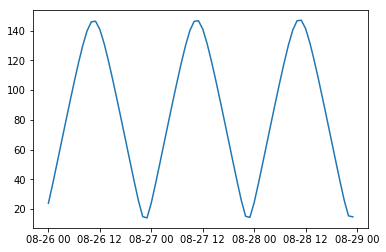

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(SolarData['zenith'])